# FIFA 

# Web Analytics

June 30 2018

#### Group 3 Members:

* Rafal Decowski 

* Tze Fung Lung  

* Yun Mai

* Ahsanul Choudhury

**Project Objectives:**

1.	Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

2.	Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

3.	What can you infer about each of the distinct groups?

**Data**

Kaggle FIFA World Cup

Weather: https://www.worldweatheronline.com  

**Objective**

Use network method to find out the most successful teams. 

Test if the stadiums conditions contributed to teams performance. 


In [1]:
import nltk
import re
from nltk.sem import extract_rels,rtuple
import pandas as pd
import numpy as np
import sklearn
from bs4 import BeautifulSoup
from bs4 import Tag
import csv
import urllib3
import networkx as nx
from networkx.algorithms import bipartite as bi
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
worldcup=pd.read_csv("https://raw.githubusercontent.com/YunMai-SPS/DATA620_homework/master/DATA620_project_2/WorldCups.csv",encoding='utf-8')
wcm=pd.read_csv("https://raw.githubusercontent.com/YunMai-SPS/DATA620_homework/master/DATA620_project_2/WorldCupMatches.csv",encoding = "ISO-8859-1")
players_dt=pd.read_csv("https://raw.githubusercontent.com/YunMai-SPS/DATA620_homework/master/DATA620_project_2/WorldCupPlayers.csv",encoding='utf-8')

In [3]:
worldcup.head()

Year      Country      Winner      Runners-Up    Third      Fourth  \
0  1930      Uruguay     Uruguay       Argentina      USA  Yugoslavia   
1  1934        Italy       Italy  Czechoslovakia  Germany     Austria   
2  1938       France       Italy         Hungary   Brazil      Sweden   
3  1950       Brazil     Uruguay          Brazil   Sweden       Spain   
4  1954  Switzerland  Germany FR         Hungary  Austria     Uruguay   

   GoalsScored  QualifiedTeams  MatchesPlayed Attendance  
0           70              13             18    590.549  
1           70              16             17    363.000  
2           84              15             18    375.700  
3           88              13             22  1.045.246  
4          140              16             26    768.607

In [4]:
wcm.head()

Year              Datetime  temp  humidity  wind.speed  precip.accum  \
0  1930  13 Jul 1930 - 15:00    NaN       NaN         NaN           NaN   
1  1930  13 Jul 1930 - 15:00    NaN       NaN         NaN           NaN   
2  1930  14 Jul 1930 - 12:45    NaN       NaN         NaN           NaN   
3  1930  14 Jul 1930 - 14:50    NaN       NaN         NaN           NaN   
4  1930  15 Jul 1930 - 16:00    NaN       NaN         NaN           NaN   

     Stage         Stadium         City Host Counrty  ...    \
0  Group 1         Pocitos  Montevideo            UY  ...     
1  Group 4  Parque Central  Montevideo            UY  ...     
2  Group 2  Parque Central  Montevideo            UY  ...     
3  Group 3         Pocitos  Montevideo            UY  ...     
4  Group 1  Parque Central  Montevideo            UY  ...     

  Half-time Away Goals                 Referee               Assistant 1  \
0                    0  LOMBARDI Domingo (URU)     CRISTOPHE Henry (BEL)   
1                    0       MACIAS Jose (ARG)  MATEUCCI Francisco (URU)   
2                    0     TEJADA Anibal (URU)   VALLARINO Ricardo (URU)   
3                    0   WARNKEN Alberto (CHI)       LANGENUS Jean (BEL)   
4                    0     REGO Gilberto (BRA)      SAUCEDO Ulises (BOL)   

                  Assistant 2 RoundID  MatchID  Home Team Initials  \
0         REGO Gilberto (BRA)     201     1096                 FRA   
1       WARNKEN Alberto (CHI)     201     1090                 USA   
2         BALWAY Thomas (FRA)     201     1093                 YUG   
3    MATEUCCI Francisco (URU)     201     1098                 ROU   
4  RADULESCU Constantin (ROU)     201     1085                 ARG   

   Away Team Initials Homewin goldif  
0                 MEX       1      3  
1                 BEL       1      3  
2                 BRA       1      1  
3                 PER       1      2  
4                 FRA       1      1  

[5 rows x 27 columns]

In [5]:
players_dt.head()

RoundID  MatchID Team Initials           Coach Name Line-up  Shirt Number  \
0      201     1096           FRA  CAUDRON Raoul (FRA)       S             0   
1      201     1096           MEX     LUQUE Juan (MEX)       S             0   
2      201     1096           FRA  CAUDRON Raoul (FRA)       S             0   
3      201     1096           MEX     LUQUE Juan (MEX)       S             0   
4      201     1096           FRA  CAUDRON Raoul (FRA)       S             0   

        Player Name Position Event  
0       Alex THEPOT       GK   NaN  
1   Oscar BONFIGLIO       GK   NaN  
2  Marcel LANGILLER      NaN  G40'  
3      Juan CARRENO      NaN  G70'  
4   Ernest LIBERATI      NaN   NaN

# 1. Explore the data

## 1.1 View the connection between teams and players 

* Create a bipartite network with coutries/teams and players as left- and right-side respectively.

* The green nodes are coutries/teams and the beige nodes are players.

* The orange nodes are players played for more than one team.

In [6]:
countries = (wcm['Home Team Initials'].append(wcm['Away Team Initials'])).unique()
players = players_dt['Player Name'].unique()

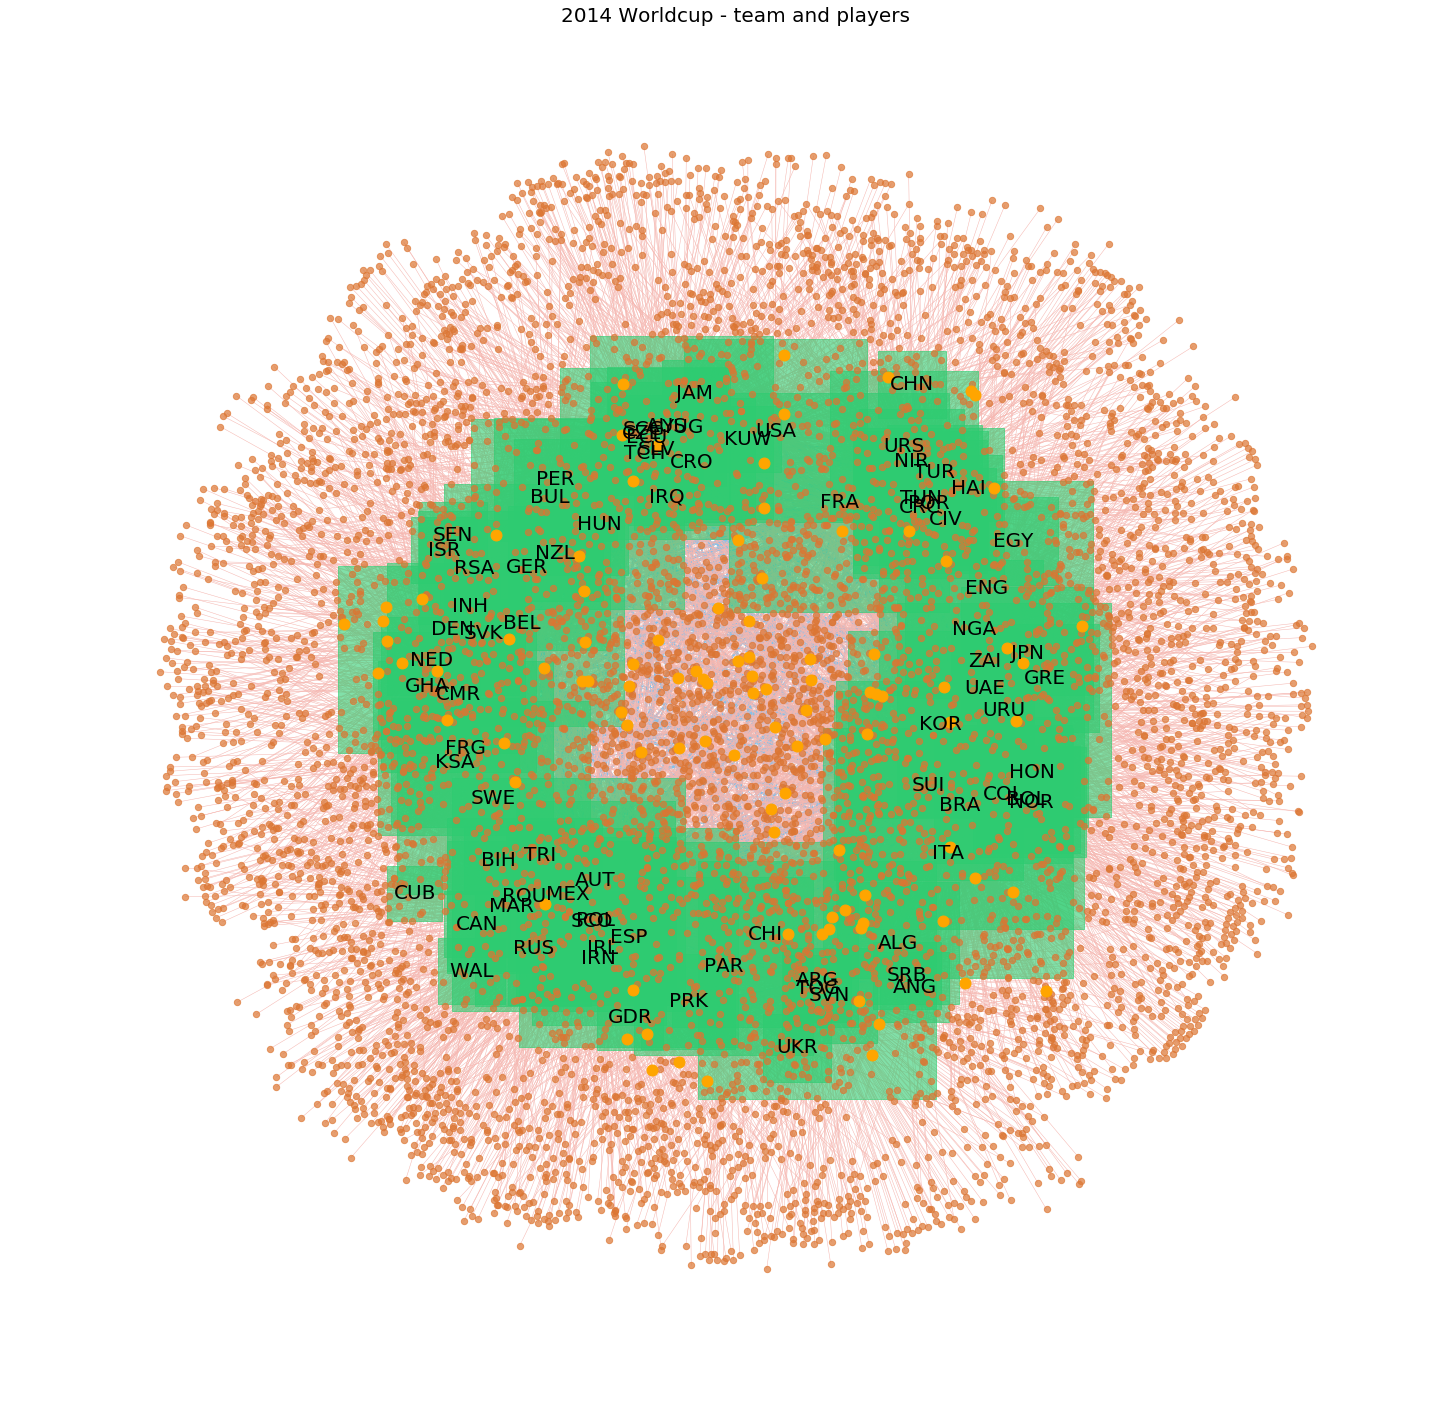

In [7]:
plt.figure(figsize=(25, 25))

# Create the graph
g=nx.from_pandas_dataframe(players_dt,'Player Name','Team Initials')

# Create a layout for our nodes 
pos = nx.spring_layout(g,k=0.1)

# Go through every country's name and multiply that by 80 to get the circle size
country_size = [g.degree(country) * 200 for country in countries]

# Draw countries nodes
nx.draw_networkx_nodes(g, 
                       pos,
                       nodelist=list(countries),
                       node_size=country_size, # a LIST of sizes, based on g.degree
                       node_color='#2ECC71', ##FA8072 #58D68D
                       alpha=0.6, 
                       node_shape='s')
# Draw players nodes
nx.draw_networkx_nodes(g, pos, nodelist=list(players), with_labels=False, node_color='#DC7633', alpha=0.7, node_size=40)  #5DADE2 #EDBB99

# Draw popular players
popular_player = [player for player in players if g.degree(player) > 1]
nx.draw_networkx_nodes(g, pos, nodelist=list(popular_player), with_labels=False, node_color='orange', alpha=1, node_size=120) #FF0000

# Only add labels to the countries
labels = {}    
for node in list(g.nodes()):
    if node in list(countries):
        #set the node name as the key and the label as its value 
        labels[node] = node
        
nx.draw_networkx_labels(g, pos, labels=labels,font_size=20) #option font_color='r'

# Add edges between countries
g.add_weighted_edges_from([tuple(d) for d in wcm[['Home Team Initials','Away Team Initials','goldif']].values])
country_edges =list(wcm[['Home Team Initials','Away Team Initials']].apply(tuple, axis=1))
selected_edges = [(u,v) for u,v in g.edges if (u,v) in country_edges]
weights = [g[u][v]['weight'] for u,v in selected_edges]
nx.draw_networkx_edges(g, pos, edgelist=country_edges,edge_color="#85C1E9",width=weights) #AAB7B8


# add edges between players and countries
selected_edges_2 = [(u,v) for u,v in g.edges if not (u,v) in country_edges]
nx.draw_networkx_edges(g, pos, edgelist=selected_edges_2,edge_color="#F5B7B1",width=0.5) #AAB7B8

# Plot options
plt.axis('off')
plt.title("2014 Worldcup - team and players",fontsize=20)
plt.show()

## 1.2 View the connection between teams and players in 2014

* Create a network with coutries/teams and players as nodes.

* The green nodes are coutries/teams and the beige nodes are players.

* The red nodes are players played for more than one team.

* The network are not bipartite network.

In [8]:
# Subseting the 2014 data

match_2014 = wcm[wcm.Year==2014]

countries_2014 = (match_2014['Home Team Initials'].append(match_2014['Away Team Initials'])).unique()

players_dt_2014 = players_dt[players_dt['MatchID'].isin (match_2014['MatchID'])]
players_2014 = players_dt_2014['Player Name'].unique()

print('\033[1m' + '\033[94m'+ "This is a data set for the",len(set(countries_2014)), "teams quilified for the Wolrd Cup Final tournament in 2014.")

This is a data set for the 32 teams quilified for the Wolrd Cup Final tournament in 2014.


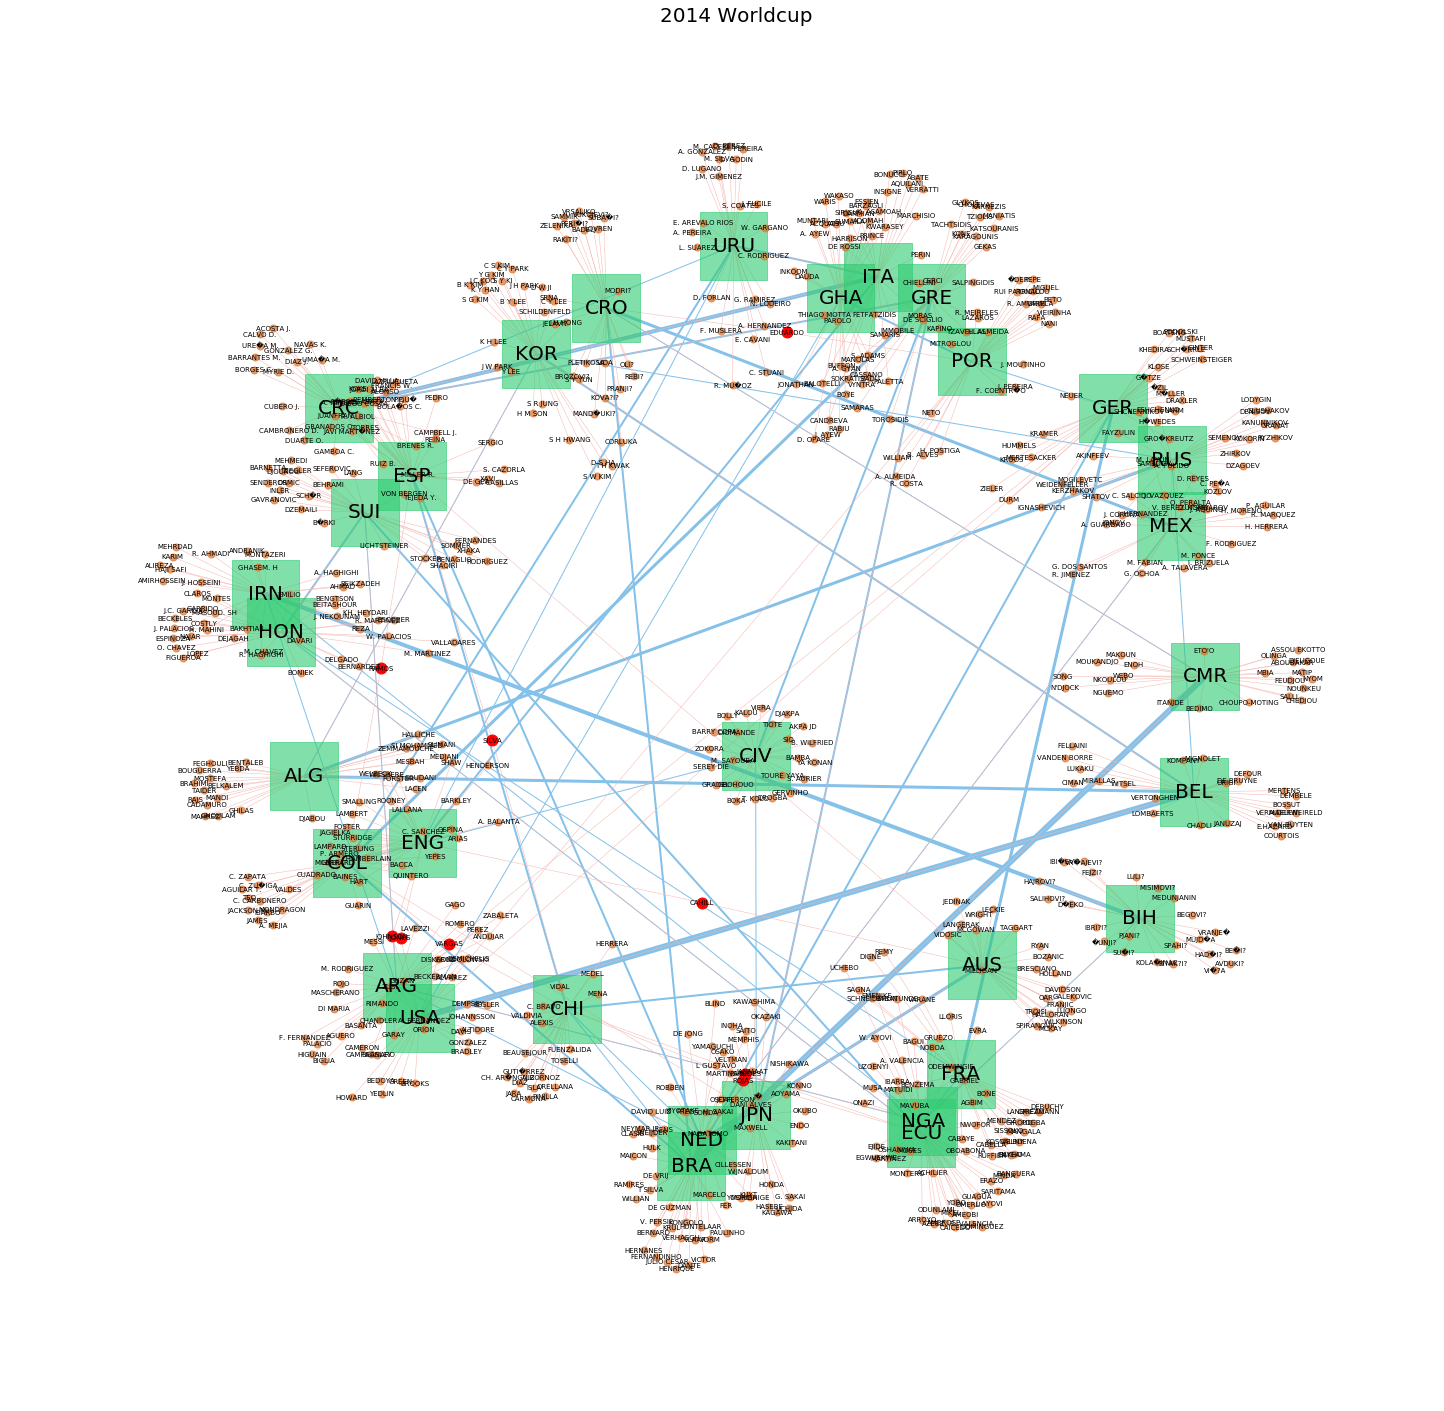

In [9]:
plt.figure(figsize=(25, 25))

# Create the graph
g=nx.from_pandas_dataframe(players_dt_2014,'Player Name','Team Initials')

# Create a layout for our nodes 
pos = nx.spring_layout(g,k=0.1)

# Go through every country's name and multiply that by 80 to get the circle size
country_size = [g.degree(country) * 200 for country in countries_2014]

# Draw countries nodes
nx.draw_networkx_nodes(g, 
                       pos,
                       nodelist=list(countries_2014),
                       node_size=country_size, # a LIST of sizes, based on g.degree
                       node_color='#2ECC71', ##FA8072 #58D68D
                       alpha=0.6, 
                       node_shape='s')
# Draw players nodes
nx.draw_networkx_nodes(g, pos, nodelist=list(players_2014), with_labels=False, node_color='#DC7633', alpha=0.7, node_size=50)  #5DADE2 #EDBB99

# Draw popular players
popular_player = [player for player in players_2014 if g.degree(player) > 1]
nx.draw_networkx_nodes(g, pos, nodelist=list(popular_player), with_labels=False, node_color='#FF0000', alpha=1, node_size=120) #FF0000

# Add labels to the countries
labels = {}    
for node in list(g.nodes()):
    if node in list(countries_2014):
        #set the node name as the key and the label as its value 
        labels[node] = node      
nx.draw_networkx_labels(g, pos, labels=labels,font_size=20) #option font_color='r'

# Add labels to the players
labels_p = {}    
for node in list(g.nodes()):
    if node in list(players_2014):
        #set the node name as the key and the label as its value 
        labels_p[node] = node
nx.draw_networkx_labels(g, pos, labels=labels_p,font_size=7) #option font_color='r'

# Add edges between countries
g.add_weighted_edges_from([tuple(d) for d in match_2014[['Home Team Initials','Away Team Initials','goldif']].values])
country_edges =list(match_2014[['Home Team Initials','Away Team Initials']].apply(tuple, axis=1))
selected_edges = [(u,v) for u,v in g.edges if (u,v) in country_edges]
edges = g.edges()
weights = [g[u][v]['weight'] for u,v in selected_edges]
nx.draw_networkx_edges(g, pos, edgelist=country_edges,edge_color="#85C1E9",width=weights) #AAB7B8


# add edges between players and countries
selected_edges_2 = [(u,v) for u,v in g.edges if not (u,v) in country_edges]
nx.draw_networkx_edges(g, pos, edgelist=selected_edges_2,edge_color="#F5B7B1",width=0.5) #AAB7B8

# Plot options
plt.axis('off')
plt.title("2014 Worldcup",fontsize=20)
plt.show()

### There are some players(marked in red) played for more than one teams in 2014 world cup. For example, Ramos played for both Spain and Columbia and Jones played for both England and USA. 

## 1.3 Connection Between Stadiums and Teams

### Construct a straightforward view of the connection between the stadium and teams.

Is the network a bipartite graph?  True


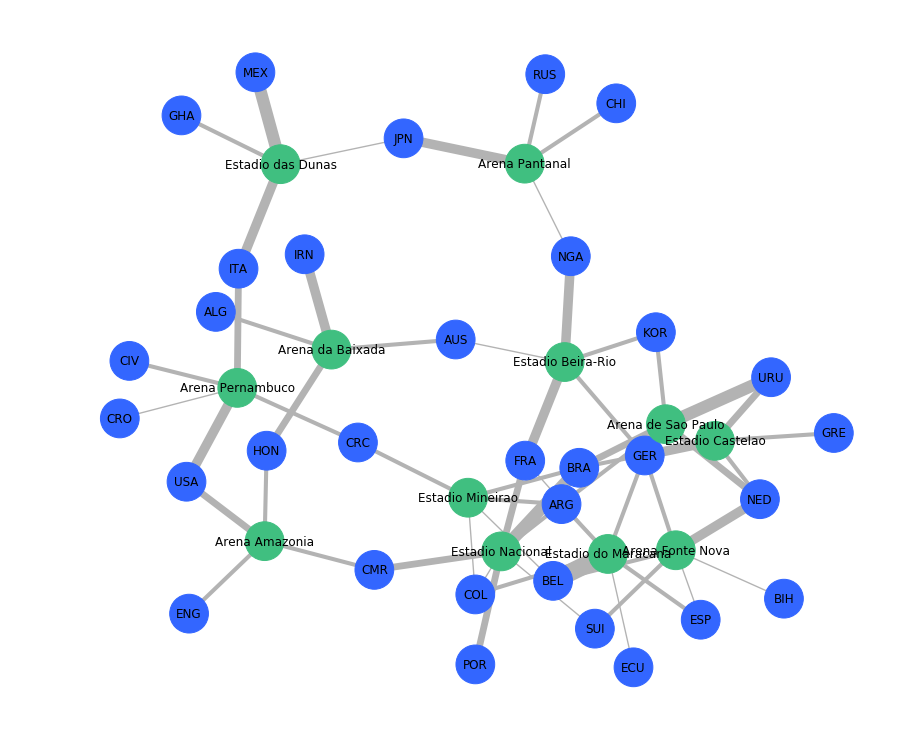

In [10]:
B = nx.Graph()
B.add_nodes_from(wcm[wcm.Year == 2014.0]['Home Team Initials'], bipartite =0)
B.add_nodes_from(wcm[wcm.Year == 2014.0]['Stadium'], bipartite=1)
B.add_edges_from(list(zip(wcm[wcm.Year == 2014.0]['Home Team Initials'], wcm[wcm.Year == 2014.0]['Stadium'])))

c = bi.clustering(B)
c = bi.clustering(B,mode='min')

#### Bipartite test

print("Is the network a bipartite graph? ",bi.is_bipartite(B))

bottom_nodes, top_nodes = bi.sets(B)
# Colors
colors = ['#3366ff' for i in range(len(bottom_nodes))] + ['#40bf80' for i in range(len(top_nodes))]

# Size
edge_size = list(wcm[wcm.Year == 2014.0].goldif+0.5)

# Network graph

plt.rcParams['figure.figsize'] = [12, 10]
degree_graph = nx.draw_kamada_kawai(B, 
                                    node_color=colors,
                                    edge_color='#b3b3b3',   
                                    node_size=1500, 
                                    with_labels=True, 
                                    width=np.multiply(edge_size, (np.e)))

In [11]:
degX,degY=bi.degrees(B,top_nodes)
dict(degY)

{'Arena Amazonia': 4,
 'Arena Fonte Nova': 6,
 'Arena Pantanal': 4,
 'Arena Pernambuco': 5,
 'Arena da Baixada': 4,
 'Arena de Sao Paulo': 5,
 'Estadio Beira-Rio': 5,
 'Estadio Castelao': 5,
 'Estadio Mineirao': 5,
 'Estadio Nacional': 7,
 'Estadio das Dunas': 4,
 'Estadio do Maracana': 7}

### The stadiums held at least 4 games and some held as many as 7 games in 2014. One of the two stadium that hosted 7 games, Estadio do Maracana, held the final game. 

In [12]:
dict((k, v) for k, v in dict(degX).items() if v >2 )

{'ARG': 4, 'BEL': 3, 'BRA': 4, 'COL': 3, 'FRA': 3, 'GER': 4, 'NED': 3}

### Conclusion: The teams connect to more than 2 stadiums are the 7 out of 8 teams qualified for the Quater-finals.

# 2.  Who are most successful in Quarter-finals in the history?

* The question is: which teams perform the best in the final four? Which team(s) won the most titles? 

* For the first question:

> * Construct a bipartite network between countries/teams and the awards.

> * The award of the team will be color coded. The team ever got different positions will be coded as mix color.

> * The edge thickness will represent how many times the team got a certain award in the Quarter-finals.

> * The edge color will represent the award ir connects to.

> * Draw the one nodes projection of the bipartite graph on teams. The edge weights equal to NUMBER OF SHARED PARTNERS

* For the second question:

> * How many times the team got a certain award in the Quarter-finals will be assigned to the edge attributes in the bipartite network between countries/teams and the awards.

> * Draw the one nodes projection of the bipartite graph on England. The edge weights equal to the sum of the edges weights(frequency of being winner) of the two nodes connected to node 'Winner' in the bipartite network graph subtracted by 1, or equare to 0.1 when in the bipartite network, the common node shared by the two teams are 'Fourth'.

## 2.1 Awards-team bipartite network 

In [13]:
# creaste lists for all the teams were winner, runners-up, third, and fourth
winner = list(worldcup.Winner)
RunnersUp = list(worldcup['Runners-Up'])
third = list(worldcup.Third)
fourth = list(worldcup.Fourth)

In [14]:
# the nodes sets of teams
awards=[]
awards.extend(winner+RunnersUp+third+fourth)

# the nodes sets of titles
top=[]
top.extend(['Winner']*20+['Runners-Up']*20+['Third']*20+['Fourth']*20)

In [15]:
B = nx.Graph()

# Add nodes with the node attribute "bipartite" 
B.add_nodes_from(['Winner', 'Runners-Up', 'Third', 'Fourth'], bipartite=0)
B.add_nodes_from(list(set(awards)), bipartite=1)

# Add edges only between nodes of opposite node sets
B.add_edges_from(list(zip(top,awards)))

In [16]:
# calculate the frequencies of the teams when they were winner, runners-up, third, or fourth
winner_fre = worldcup.Winner.value_counts().reset_index() 
RunnersUp_fre = worldcup['Runners-Up'].value_counts().reset_index() 
third_fre = worldcup.Third.value_counts().reset_index() 
fourth_fre = worldcup.Fourth.value_counts().reset_index() 

winner_fre

index  Winner
0      Brazil       5
1       Italy       4
2  Germany FR       3
3   Argentina       2
4     Uruguay       2
5       Spain       1
6     England       1
7      France       1
8     Germany       1

In [17]:
print('\033[1m' + '\033[94m'  'There are {} teams won the World Cup in the history.'.format(len(winner_fre)))

There are 9 teams won the World Cup in the history.


###  Let's see whether we can get the same information from the network graph.

In [18]:
#split the node to bottom_nodes, top_nodes, containing titles and teams respectively
#bottom_nodes, top_nodes = bi.sets(B) this will cause Ambiguous solution for bipartite sets because two set are both string type.
bottom_nodes={}
for n, d in B.nodes(data=True): 
    if d['bipartite']==0:
        bottom_nodes[n] = d
        
top_nodes ={}
for n, d in B.nodes(data=True): 
    if d['bipartite']==1:
        top_nodes[n] = d
        
# contruct the list for the node color and edge size
#nd_color = ['#40bf80' for i in range(len(bottom_nodes))] +['#3366ff' for i in range(len(top_nodes))]
#nd_color = ['#E5E4E2' for i in range(len(bottom_nodes))] +['#3366ff' for i in range(len(top_nodes))]
nd_shape = ['s' for i in range(len(bottom_nodes))] +['o' for i in range(len(top_nodes))] 
edge_size = bi.degrees(B,bottom_nodes)[0]

In [19]:
bi.degrees(B,bottom_nodes)

(DegreeView({'Croatia': 1, 'Sweden': 3, 'Portugal': 2, 'France': 4, 'Brazil': 4, 'USA': 1, 'Italy': 4, 'Uruguay': 2, 'Germany FR': 4, 'Korea Republic': 1, 'Soviet Union': 1, 'Yugoslavia': 1, 'Belgium': 1, 'Germany': 3, 'Argentina': 2, 'England': 2, 'Spain': 2, 'Chile': 1, 'Turkey': 1, 'Netherlands': 3, 'Bulgaria': 1, 'Czechoslovakia': 1, 'Poland': 1, 'Hungary': 1, 'Austria': 2}),
 DegreeView({'Fourth': 16, 'Third': 14, 'Runners-Up': 10, 'Winner': 9}))

In [75]:
B.edges(data=True)

EdgeDataView([('Winner', 'Uruguay', {}), ('Winner', 'Italy', {}), ('Winner', 'Germany FR', {}), ('Winner', 'Brazil', {}), ('Winner', 'England', {}), ('Winner', 'Argentina', {}), ('Winner', 'France', {}), ('Winner', 'Spain', {}), ('Winner', 'Germany', {}), ('Runners-Up', 'Argentina', {}), ('Runners-Up', 'Czechoslovakia', {}), ('Runners-Up', 'Hungary', {}), ('Runners-Up', 'Brazil', {}), ('Runners-Up', 'Sweden', {}), ('Runners-Up', 'Germany FR', {}), ('Runners-Up', 'Italy', {}), ('Runners-Up', 'Netherlands', {}), ('Runners-Up', 'Germany', {}), ('Runners-Up', 'France', {}), ('Third', 'USA', {}), ('Third', 'Germany', {}), ('Third', 'Brazil', {}), ('Third', 'Sweden', {}), ('Third', 'Austria', {}), ('Third', 'France', {}), ('Third', 'Chile', {}), ('Third', 'Portugal', {}), ('Third', 'Germany FR', {}), ('Third', 'Poland', {}), ('Third', 'Italy', {}), ('Third', 'Croatia', {}), ('Third', 'Turkey', {}), ('Third', 'Netherlands', {}), ('Fourth', 'Yugoslavia', {}), ('Fourth', 'Austria', {}), ('Fourt

### By measuring the degree of each set of nodes, we got the same results. There are 9 teams won the World Cup in the history.

### Then we set the <span style="color:red">edge weight</span> as <span style="color:red">how many times the team ends up with the winner, runners-up, third or fourth in the Quarter-finals</span>. 

In [83]:
weights=[]
for u,v in B.edges():
    if u == 'Winner':
        for cty in winner_fre['index']:
            if v==cty:
                weights += list(winner_fre.loc[winner_fre['index']==cty, 'Winner'])
for u,v in B.edges():
    if u =='Runners-Up':
        for cty in RunnersUp_fre['index']:
            if v==cty:
                weights += list(RunnersUp_fre.loc[RunnersUp_fre['index']==cty, 'Runners-Up'])
for u,v in B.edges():
    if u =='Third':
        for cty in third_fre['index']:
            if v==cty:
                weights += list(third_fre.loc[third_fre['index']==cty, 'Third'])
for u,v in B.edges():
    if u =='Fourth':
        for cty in fourth_fre['index']:
            if v==cty:
                weights += list(fourth_fre.loc[fourth_fre['index']==cty, 'Fourth'])

In [99]:
# set the frequency as edge attribute
edge_list=[]
for x in B.edges:
    edge_list.append(x)

weight_dict = dict(zip(edge_list,weights))

nx.set_edge_attributes(B, name='frequency', values=weight_dict)

### Then, we set the <span style="color:cyan;font-size: 24px">color of the edges</span> as <span style="color:red;font-size: 24px">red </span>for <span style="color:red;font-size: 24px">the winner </span>, <span style="color:yellow;font-size: 24px">yellow</span> for <span style="color:yellow;font-size: 24px">the runners-up </span>, <span style="color:blue;font-size: 24px">blue</span> for <span style="color:blue;font-size: 24px">the third </span> or  <span style="color:#E5E4E2;font-size: 24px">platinum</span> for  <span style="color:#E5E4E2;font-size: 24px"> the fourth </span> in the Quarter-finals</span>.

In [22]:
edge_colors=[]
for u,v in B.edges():
    if u =='Winner':
        edge_colors.append('red')
    elif u =='Runners-Up':
        edge_colors.append('yellow')
    elif u =='Third':
        edge_colors.append('blue')
    elif u =='Fourth':
        edge_colors.append('#E5E4E2')

### Last, we set the <span style="color:magenta;font-size: 24px">color of the nodes</span> as:

> ### <span style="color:red;font-size: 24px">red </span>for <span style="color:red;font-size: 24px">the winner </span>;

> ### <span style="color:yellow;font-size: 24px">yellow</span> for <span style="color:yellow;font-size: 24px">the runners-up </span>;

> ### <span style="color:blue;font-size: 24px">blue</span> for <span style="color:blue;font-size: 24px">the third </span>: 

> ### <span style="color:#E5E4E2;font-size: 24px">platinum</span> for  <span style="color:#E5E4E2;font-size: 24px"> the fourth </span> in the Quarter-finals</span>. 

> ### So the mixed color will be assign for the nodes who won different positions: 

> ### The team who were  <span style="color:orange;font-size: 24px">winner and runners-up</span> will be <span style="color:orange;font-size: 24px">orgnge</span>. 

> ### the team who were <span style="color:purple;font-size: 24px">winner and third</span> will be <span style="color:purple;font-size: 24px">purple</span>.  

> ### The team who were <span style="color:pink;font-size: 24px">winner and fourth</span> will be <span style="color:pink;font-size: 24px">pink</span>. 

> ### The team who were <span style="color:green;font-size: 24px">runners-up and third</span> will be <span style="color:green;font-size: 24px">green</span>. 

> ### The team who were <span style="color:#FFFF99;font-size: 24px">runners-up and fourth</span> will be <span style="color:#FFFF99;font-size: 24px">light yellow</span>. 

> ### The team who were <span style="color: #C2DFFF;font-size: 24px">third and fourth</span> will be <span style="color: #C2DFFF;font-size: 24px">light blue</span>. 

> ### The team who were <span style="color: peru;font-size: 24px">winner, runners-up and third</span> will be <span style="color:peru;font-size: 24px">brown</span>. 

> ### The team who were <span style="color: #ffcc66;font-size: 24px">winner, runners-up and fourth</span> will be <span style="color:#ffcc66;font-size: 24px">light orange</span>. 

> ### The team who were <span style="color: #b19cd9;font-size: 24px">winner, third and fourth</span> will be <span style="color:#b19cd9;font-size: 24px">light purple</span>. 

> ### The team who were <span style="color: #98FB98;font-size: 24px">runners-up, thirdand fourth</span> will be <span style="color:#98FB98;font-size: 24px">light green</span>. 

> ### The team who were <span style="color:#F5DEB3;font-size: 24px">winner, runners-up, third and fourth</span> will be <span style="color:#F5DEB3;font-size: 24px">light brown</span>. 

In [23]:
# find the overlap between winner, runners-up, third and fourth 
w_r = set(winner).intersection(RunnersUp)
w_t = set(winner).intersection(third)
w_f = set(winner).intersection(fourth)
r_t = set(RunnersUp).intersection(third)
r_f = set(RunnersUp).intersection(fourth)
t_f = set(third).intersection(fourth)

w_r_t = set(w_r).intersection(third)
w_r_f = set(w_r).intersection(fourth)
w_t_f = set(w_t).intersection(fourth)
r_t_f = set(r_t).intersection(fourth)

w_r_t_f = set(w_r_t).intersection(fourth)

In [24]:
# create a node colors function
def define_nd_color(graph):
    node_colors=[]
    for n in graph.nodes():
        if n == 'Winner':
            node_colors.append('red')
        elif n == 'Runners-Up':
            node_colors.append('yellow')
        elif n == 'Third':
            node_colors.append('blue')
        elif n == 'Fourth':
            node_colors.append('#E5E4E2')
        elif n in w_r_t_f:
            node_colors.append('#F5DEB3')
        elif n in w_r_t:
            node_colors.append('peru')
        elif n in w_r_f:
            node_colors.append('#ffcc66')
        elif n in w_t_f:
            node_colors.append('#b19cd9')
        elif n in r_t_f:
            node_colors.append('#98FB98')
        elif n in w_r:
            node_colors.append('orange')
        elif n in w_t:
            node_colors.append('purple')
        elif n in w_f:
            node_colors.append('pink')
        elif n in r_t:
            node_colors.append('green')
        elif n in r_f:
            node_colors.append('#FFFF99')
        elif n in t_f:
            node_colors.append('#C2DFFF')
        elif n in winner:
            node_colors.append('red')
        elif n in RunnersUp:
            node_colors.append('yellow') 
        elif n in third:
            node_colors.append('blue')
        elif n in fourth:
            node_colors.append('#E5E4E2')
    return node_colors

In [25]:
node_colors = define_nd_color(B)

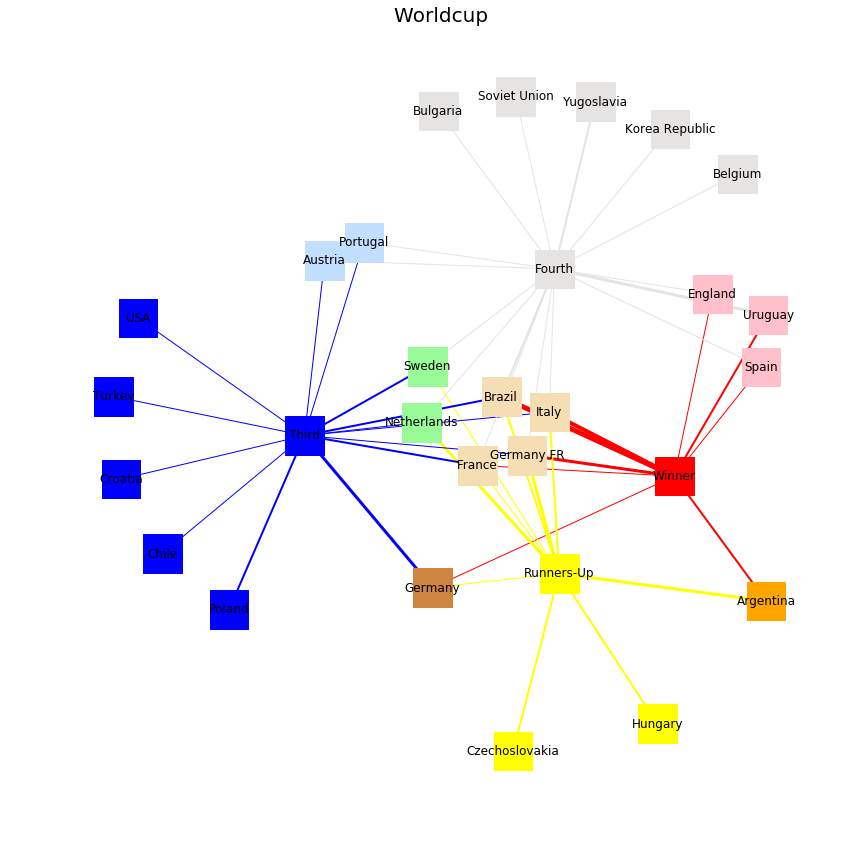

In [26]:
# draw the bipartite network graph
plt.figure(figsize=(11, 11))

plt.rcParams['figure.figsize'] = [12, 10]

degree_graph = nx.draw_kamada_kawai(B, 
                                    node_color=node_colors,
                                    edge_color=edge_colors,   
                                    node_size=1500,
                                    node_shape='s',
                                    node_alpha=0.2,                        
                                    with_labels=True, 
                                    width=weights)
#_kamada_kawai
# Plot options
plt.axis('off')
plt.title("Worldcup",fontsize=20)
plt.show()


> ### So the different combination of color red, yellow, blue, and platinum  denotes the team won more than one position: 

> ### Argitina  in  <span style="color:orange;font-size: 24px">orgnge</span> were <span style="color:red;font-size: 24px">winner </span>  and <span style="color:yellow;font-size: 24px">runners-up</span> before. 

> ### No teams <span style="color:purple;font-size: 24px">purple</span> were <span style="color:red;font-size: 24px">winner </span>  and <span style="color:blue;font-size: 24px">third  position </span> before. 

> ### No teams <span style="color:green;font-size: 24px">green</span> were <span style="color:yellow;font-size: 24px">runners-up </span>  and <span style="color:blue;font-size: 24px">third  position </span> before. 

> ### Uruguay, Spain and England  in  <span style="color:pink;font-size: 24px">pink</span> were <span style="color:red;font-size: 24px">winner </span>  and <span style="color:#E5E4E2;font-size: 24px">fourth position</span> before. 

> ### Australia and Portugal in  <span style="color:#C2DFFF;font-size: 24px">light blue</span> were <span style="color:blue;font-size: 24px">third position </span>  and <span style="color:#E5E4E2;font-size: 24px">fourth position</span> before. 

> ### Netherlands and Sweden  in  <span style="color:#98FB98;font-size: 24px">light green</span> were <span style="color:yellow;font-size: 24px">winner </span>, <span style="color:blue;font-size: 24px">third position</span>, and <span style="color:#E5E4E2;font-size: 24px">fourth position</span> before. 

> ### Germany in  <span style="color:peru;font-size: 24px">brown</span> were <span style="color:red;font-size: 24px">winner </span> ,  <span style="color:yellow;font-size: 24px">runners-up</span> and <span style="color:blue;font-size: 24px">third position</span> before. 

> ### Germany FR, France, Brazil and Italy in  <span style="color:#F5DEB3;font-size: 24px">light brown</span> were <span style="color:red;font-size: 24px">winner </span> ,  <span style="color:yellow;font-size: 24px">runners-up</span> , <span style="color:blue;font-size: 24px">third position</span>, and <span style="color:#E5E4E2;font-size: 24px">fourth position</span> before. 

## 2.2 Unipartite network graph

### In order to find out which teams perform the best in the final four, we plot the unipartite graph on nodes of teams. We did this by drawing the one nodes projection of the bipartite graph on teams. The <span style="color:red;font-size: 24px">edge weights</span> equal to <span style="color:red;font-size: 24px">NUMBER OF SHARED PARTNERS</span>. The node colors keep the same to the original bipartite network.

In [27]:
team_win = bi.generic_weighted_projected_graph(B, top_nodes)
#team_win = nx.connected_component_subgraphs(team_win)[0]

In [28]:
team_win.nodes()

NodeView(('Portugal', 'France', 'Brazil', 'USA', 'Uruguay', 'Germany FR', 'Korea Republic', 'Yugoslavia', 'Turkey', 'Netherlands', 'Bulgaria', 'Czechoslovakia', 'Hungary', 'Austria', 'Croatia', 'Soviet Union', 'Germany', 'Argentina', 'Spain', 'Chile', 'Belgium', 'Italy', 'Poland', 'Sweden', 'England'))

In [29]:
# create the list for node colors
node_colors = define_nd_color(team_win)

In [30]:
team_win.edges(data=True)

EdgeDataView([('Portugal', 'Croatia', {'weight': 1}), ('Portugal', 'France', {'weight': 2}), ('Portugal', 'Brazil', {'weight': 2}), ('Portugal', 'USA', {'weight': 1}), ('Portugal', 'Uruguay', {'weight': 1}), ('Portugal', 'Germany FR', {'weight': 2}), ('Portugal', 'Korea Republic', {'weight': 1}), ('Portugal', 'Soviet Union', {'weight': 1}), ('Portugal', 'Yugoslavia', {'weight': 1}), ('Portugal', 'Germany', {'weight': 1}), ('Portugal', 'England', {'weight': 1}), ('Portugal', 'Spain', {'weight': 1}), ('Portugal', 'Chile', {'weight': 1}), ('Portugal', 'Turkey', {'weight': 1}), ('Portugal', 'Bulgaria', {'weight': 1}), ('Portugal', 'Netherlands', {'weight': 2}), ('Portugal', 'Belgium', {'weight': 1}), ('Portugal', 'Italy', {'weight': 2}), ('Portugal', 'Poland', {'weight': 1}), ('Portugal', 'Sweden', {'weight': 2}), ('Portugal', 'Austria', {'weight': 2}), ('France', 'Croatia', {'weight': 1}), ('France', 'Sweden', {'weight': 3}), ('France', 'Brazil', {'weight': 4}), ('France', 'USA', {'weight

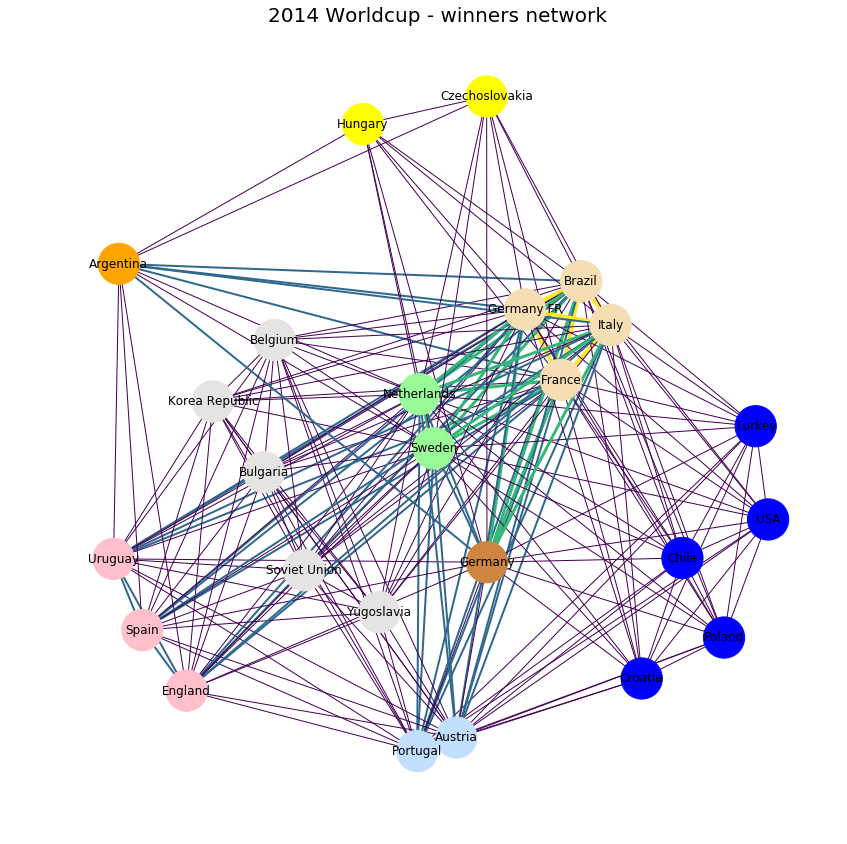

In [31]:
#edge weight of the unipartite graph equare to NUMBER OF SHARED PARTNERS, which we could obtained from the edge attributes of the unipartite projections of the team-awrds bipartite graph.
weights=[]
for u,v in team_win.edges:
    weights.append(team_win.edges[(u,v)]['weight'])


plt.rcParams['figure.figsize'] = [11, 11]
one_mode_graph = nx.draw_kamada_kawai(team_win, 
                                       node_color=node_colors,
                                       edge_color=weights,   
                                       node_size=1700,
                                       node_shape='o',
                                       with_labels=True, 
                                       width=weights)

plt.axis('off')
plt.title("2014 Worldcup - winners network ",fontsize=20)
plt.show()

### In the projection graph on the teams, the nodes of the same color tend to be closer than nodes of different colors. The teams who got only one type of awards connect to other teams only with the thinnest edges in purple. The teams who got more than one type of awards connect to other teams not only with thicker edges because they have more shared awards nodes in the bipartite graph.

## 2.3 Extract the important nodes by trimming the network

### Trimming the unipartite network graph by removal of the teams conneted by relative lower edge weight (<span style="color:magenta;font-size: 24px">number of shared award nodes</span>) will be helpful in find the most successful teams. To determine where to place the “water level”, we plot a  <span style="color:magenta;font-size: 24px">histogram of edge weights</span> . The <span style="color:red;font-size: 24px"> Y-axis</span> in the histogram is <span style="color:cyan;font-size: 24px">the counts</span>  of <span style="color:red;font-size: 24px">each category of edge weight</span>  in the unipartite network graph. This histogram told us that most of the nodes (155/(155+40+10+5), ~70%)in the unipartite network have only 1 shared award nodes.


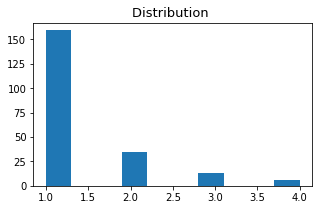

In [32]:
plt.figure(figsize=(5, 3))

plt.hist(weights)

plt.title("Distribution ",fontsize=13)
plt.show()


### From the histogram, we can see there are 4 different weights: 1, 2, 3, and 4, which represnet the number of shared neighbors(the award nodes) in this situation. Approximately 70% of edges are weighted 1, so we can safely remove them.


## Separate the graph into subparts using the island method

In [33]:
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
    return g2

In [34]:
def island_method(g, iterations=1):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))

    #compute the size of the step, so we get a reasonable step in iterations
    step=1
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [35]:
cc=sorted(nx.connected_component_subgraphs(team_win), key = len, reverse=True)[0]
islands=island_method(cc)
sorted(nx.connected_component_subgraphs(islands[0][1]), key = len, reverse=True)

for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print (i[0],len(i[1]),len(sorted(nx.connected_component_subgraphs(i[1]), key = len, reverse=True)))

1 13 1
2 7 1
3 4 1


### By iterating different cut-off from 1 to 3, we got three trimmed graphs with the number of nodes as 13, 7 and 4 respectively. None of the trimmed graphs has more than one subgraph. This suggests there is no clusters or islands structure in this unipartite network graph. 

## Teams received a award more than twice in the Quarter-finals 

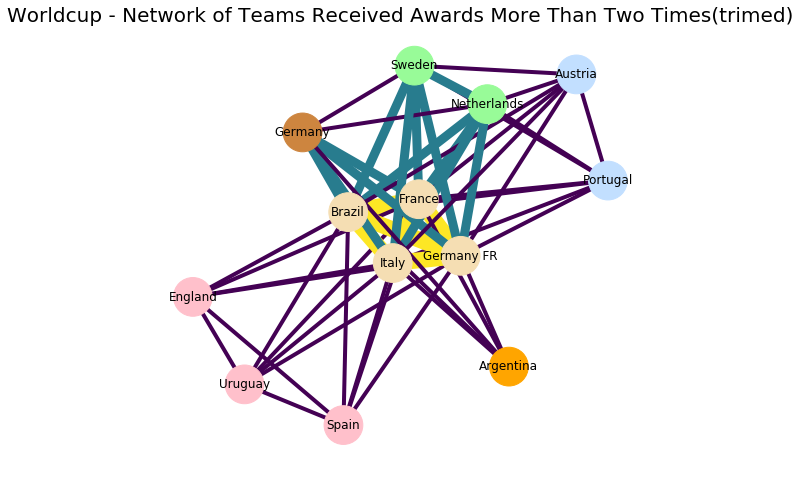

In [36]:
winner_trim=trim_edges(team_win, weight=1)

# create the list for node colors
node_colors = define_nd_color(winner_trim)

## re-calculate weights based on the new graph
## assign exponentiation weight to edges for better view
weights=[edata['weight']**2 for u,v,edata in winner_trim.edges(data=True)]

plt.rcParams['figure.figsize'] = [9, 8]
nx.draw_networkx(winner_trim, width=weights, edge_color=weights, node_color = node_colors, node_size=1500)

plt.axis('off')
plt.title("Worldcup - Network of Teams Received Awards More Than Two Times",fontsize=20)
plt.show()

## Conclusion:

### By deleting the teams who only got one award in the history, we got a smaller network with teams got at least two types of awards in the history.  Brazil, France, Italy, and Germany FR are located in the middle of the network and each of them connect to the teams in the orange, pink, light blue,  light green, and brown group. They are the teams that received all four type of awards in the World Cup Soccer history.

## 2.4 Who won the most titles in the history?

### To find out who won the most, we plot the unipartite graph on one of the teams who won the champion only once in the history. The ideal node for the projection is the one who only won the champion (node color in  <span style="color:red;font-size: 24px">red</span>) but not other awards. However, we have none of such team. So we chose one team who got at most two types of awards in the history. We plot the unipartite graph by drawing the one nodes projection of the bipartite graph on England. The <span style="color:red;font-size: 24px">edge weights</span> equal to <span style="color:red;font-size: 24px">the sum of the edges weights(frequency of obtaining certain award) of the two nodes connected to node 'Winner' in the bipartite network graph subtracted by 1 - the frequency of England won the gold medal</span>, or equare to <span style="color:green;font-size: 24px">0.1 when in the bipartite network, the common node shared by the two teams are 'Fourth'- the other node that England connects to,  the node we don't care about</span>. The node colors keep the same to the original bipartite network.

In [149]:
def edge_weight(G, u, v, weight='frequency'):
    w = 0
    for nbr in set(G[u]) & set(G[v]):
        if nbr != 'Fourth':
            w += G[u][nbr].get(weight, 1) + G[v][nbr].get(weight, 1)
        w = round(w-1)
        if nbr == 'Fourth':
            w = 0.1
    return w

champions = bi.generic_weighted_projected_graph(B, ['England'], weight_function = edge_weight)
                #['Winner','Brazil','Italy','Argentina', 'Uruguay', 'France','Germany FR','Germany','England','Spain'])

In [146]:
champions.nodes()

NodeView(('England', 'Portugal', 'France', 'Brazil', 'Austria', 'Uruguay', 'Germany FR', 'Soviet Union', 'Korea Republic', 'Yugoslavia', 'Germany', 'Argentina', 'Spain', 'Bulgaria', 'Netherlands', 'Belgium', 'Italy', 'Sweden'))

In [147]:
# create the list for node colors
node_colors = define_nd_color(champions)

In [150]:
champions.edges(data=True)

EdgeDataView([('England', 'Portugal', {'weight': 0.1}), ('England', 'France', {'weight': 1.0}), ('England', 'Brazil', {'weight': 5.0}), ('England', 'Austria', {'weight': 0.1}), ('England', 'Uruguay', {'weight': 2.0}), ('England', 'Germany FR', {'weight': 3.0}), ('England', 'Soviet Union', {'weight': 0.1}), ('England', 'Korea Republic', {'weight': 0.1}), ('England', 'Yugoslavia', {'weight': 0.1}), ('England', 'Germany', {'weight': 1}), ('England', 'Argentina', {'weight': 2}), ('England', 'Spain', {'weight': 1.0}), ('England', 'Bulgaria', {'weight': 0.1}), ('England', 'Netherlands', {'weight': 0.1}), ('England', 'Belgium', {'weight': 0.1}), ('England', 'Italy', {'weight': 4.0}), ('England', 'Sweden', {'weight': 0.1})])

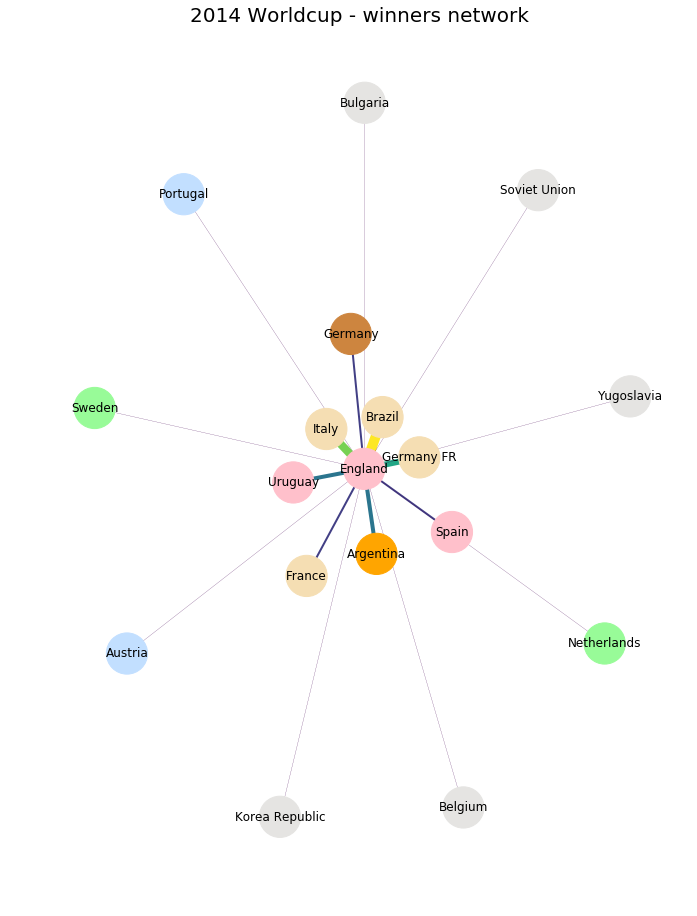

In [160]:
#edge weight of the unipartite graph equare to NUMBER OF SHARED PARTNERS, which we could obtained from the edge attributes of the unipartite projections of the team-awrds bipartite graph.
weights=[]
for u,v in champions.edges:
    weights.append(champions.edges[(u,v)]['weight']*2)


plt.rcParams['figure.figsize'] = [9, 12]
one_mode_graph = nx.draw(champions, 
                           node_color=node_colors,
                           edge_color=weights,   
                           node_size=1700,
                           node_shape='o',
                           with_labels=True, 
                           width=weights) #_kamada_kawai

plt.axis('off')
plt.title("2014 Worldcup - winners network ",fontsize=20)
plt.show()

### Find the team won more than three times in the history

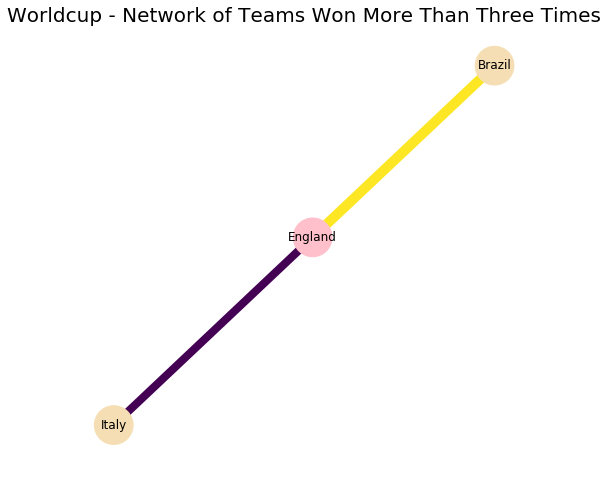

In [165]:
champions_trim = trim_edges(champions, weight=3)

# create the list for node colors
node_colors = define_nd_color(champions_trim)

## re-calculate weights based on the new graph
## assign exponentiation weight to edges for better view
weights=[edata['weight']*2 for u,v,edata in champions_trim.edges(data=True)]

plt.rcParams['figure.figsize'] = [9, 8]
nx.draw_networkx(champions_trim, width=weights, edge_color=weights, node_color = node_colors, node_size=1500)

plt.axis('off')
plt.title("Worldcup - Network of Teams Won More Than Three Times",fontsize=20)
plt.show()

### Find the team won more than four times in the history

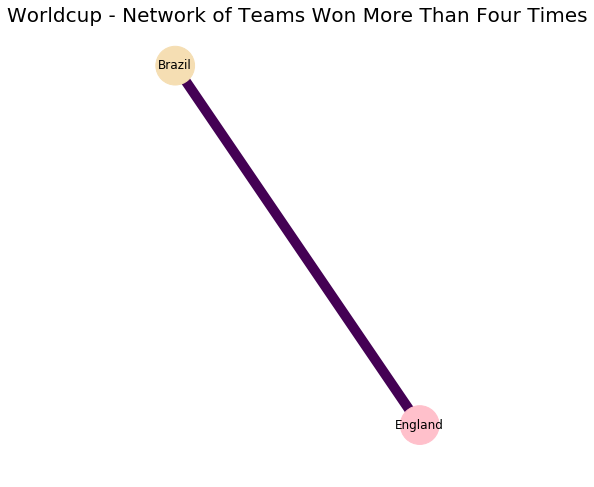

In [166]:
champions_trim = trim_edges(champions, weight=4)

## re-calculate weights based on the new graph
## assign exponentiation weight to edges for better view
weights=[edata['weight']*2 for u,v,edata in champions_trim.edges(data=True)]

plt.rcParams['figure.figsize'] = [9, 8]
nx.draw_networkx(champions_trim, width=weights, edge_color=weights, node_color = node_colors, node_size=1500)

plt.axis('off')
plt.title("Worldcup - Network of Teams Won More Than Four Times",fontsize=20)
plt.show()

In [176]:
champions_trim['England']['Brazil'].get('weight', 1) 

5.0

## Conclusion:

> ###  1). The nodes with color made by mixing red and other color/colors are the teams ever won the champion in the history, including <span style="color:#F5DEB3;font-size: 24px">Brazil, Italy,  France, Germay FR,</span> <span style="color:pink;font-size: 24px">Uruguay,England, Spain,</span> <span style="color:orange;font-size: 24px">Agentina,</span> <span style="color:peru;font-size: 24px">Germany</span>. The nodes in cold colors like platinum, light blue, light green are teams the teams never won gold medal in the history. 

> ###  2). Brazil won the most titles (5) in the history.

# 3. The relationship between the temperature and the score.

* The question is: Do the teams perform better under what kind of weather conditions?

> * Construct a bipartite network between number of goal differential and temperature.

> * The node size of the goal differential node equal to the number of goal differential.

> * The edge thickness will represent the number of goal differential.

> * Draw the one nodes projection of the bipartite graph on temperature. The edge weights equal to the sum of the edges weights(winning team) of the two nodes connected to a common award node in the bipartite network.


## 3.1 Bipartitie network of temperature and teams with goals as the edge weight.

In [177]:
a = wcm[wcm.Year == 2014.0] [['goldif','temp']]
a['duplicated'] = wcm[wcm.Year == 2014.0] [['goldif','temp']].duplicated(keep=False)
a.groupby(a.columns.tolist()).apply(lambda x: tuple(x.index)).tolist()

[(794, 819),
 (798, 830),
 (829,),
 (779, 797, 809, 825),
 (804,),
 (777, 833),
 (813,),
 (807,),
 (810,),
 (776,),
 (828,),
 (796, 811),
 (808,),
 (832,),
 (775, 783, 792, 821),
 (782, 790),
 (803,),
 (773, 795, 827, 835),
 (772, 789, 802),
 (805, 818, 822, 826),
 (774, 799),
 (788,),
 (785,),
 (781, 831),
 (787, 800),
 (823,),
 (815, 817),
 (834,),
 (812,),
 (814,),
 (820,),
 (786,),
 (816,),
 (780, 791),
 (806, 824),
 (801,),
 (784,),
 (793,),
 (778,)]

### Average the weights(temperature) of duplicate edges

In [178]:
tmpt_2014 = wcm[wcm.Year == 2014.0]

tmpt_2014['goldif'].loc[[794]] = tmpt_2014['goldif'].loc[[794, 819]].mean(axis=0)
tmpt_2014['goldif'].loc[[798]] = tmpt_2014['goldif'].loc[[798, 830]].mean(axis=0) 
tmpt_2014['goldif'].loc[[779]] = tmpt_2014['goldif'].loc[[779, 797, 809, 825]].mean(axis=0) 
tmpt_2014['goldif'].loc[[777]] = tmpt_2014['goldif'].loc[[777, 833]].mean(axis=0)
tmpt_2014['goldif'].loc[[796]] = tmpt_2014['goldif'].loc[[796, 811]].mean(axis=0) 
tmpt_2014['goldif'].loc[[775]] = tmpt_2014['goldif'].loc[[775, 783, 792, 821]].mean(axis=0)
tmpt_2014['goldif'].loc[[782]] = tmpt_2014['goldif'].loc[[782, 790]].mean(axis=0) 
tmpt_2014['goldif'].loc[[773]] = tmpt_2014['goldif'].loc[[773, 795, 827, 835]].mean(axis=0) 
tmpt_2014['goldif'].loc[[772]] = tmpt_2014['goldif'].loc[[772, 789, 802]].mean(axis=0)
tmpt_2014['goldif'].loc[[805]] = tmpt_2014['goldif'].loc[[805, 818, 822, 826]].mean(axis=0) 
tmpt_2014['goldif'].loc[[774]] = tmpt_2014['goldif'].loc[[774, 799]].mean(axis=0)
tmpt_2014['goldif'].loc[[781]] = tmpt_2014['goldif'].loc[[781, 831]].mean(axis=0) 
tmpt_2014['goldif'].loc[[787]] = tmpt_2014['goldif'].loc[[787, 800]].mean(axis=0) 
tmpt_2014['goldif'].loc[[815]] = tmpt_2014['goldif'].loc[[815, 817]].mean(axis=0)
tmpt_2014['goldif'].loc[[780]] = tmpt_2014['goldif'].loc[[780, 791]].mean(axis=0) 
tmpt_2014['goldif'].loc[[806]] = tmpt_2014['goldif'].loc[[806, 824]].mean(axis=0)

t = tmpt_2014.loc[[819,830,797, 809, 825, 833,811,783, 792, 821,
                                790,795, 827, 835,789, 802,818, 822, 826,
                               799,831,800, 817,791,824]]

tmpt_2014 = tmpt_2014.drop(t.index, axis=0)



### Node size and edge size

In [234]:
B = nx.from_pandas_dataframe(tmpt_2014, 'goldif', 'temp', edge_attr=['goldif'])
sorted(nx.connected_component_subgraphs(B), key = len, reverse=True)

In [235]:
len(tmpt_2014) == B.number_of_edges()

True

In [236]:
B.edges()

EdgeView([(1.0, 81.0), (1.0, 79.0), (1.0, 86.0), (1.0, 73.0), (1.0, 61.0), (1.0, 75.0), (1.0, 88.0), (1.0, 70.0), (1.0, 77.0), (1.0, 82.0), (1.0, 55.0), (1.0, 71.0), (1.0, 59.0), (1.0, 68.0), (1.0, 72.0), (81.0, 3.0), (81.0, 2.0), (79.0, 0.0), (79.0, 3.0), (79.0, 4.0), (79.0, 2.0), (86.0, 2.0), (73.0, 2.0), (73.0, 3.0), (0.0, 75.0), (0.0, 68.0), (0.0, 70.0), (0.0, 77.0), (0.0, 84.0), (0.0, 71.0), (6.0, 68.0), (68.0, 2.0), (68.0, 3.0), (75.0, 2.0), (75.0, 4.0), (3.0, 69.0), (3.0, 66.0), (2.0, 77.0), (4.0, 84.0)])

In [237]:
bottom_nodes, top_nodes = bi.sets(B)

nd_color = []
for nd in B.nodes():
    if nd < 7.0:
        nd_color.append('#40bf80')
    else:
        nd_color.append('#3366ff')

nd_size = []
for nd in B.nodes():
    if nd < 7.0:
        nd_size.append((nd+1)*20)
    else:
        nd_size.append(nd)

nd_size = [(x+0.2)*30 for x in nd_size]

### Draw the network

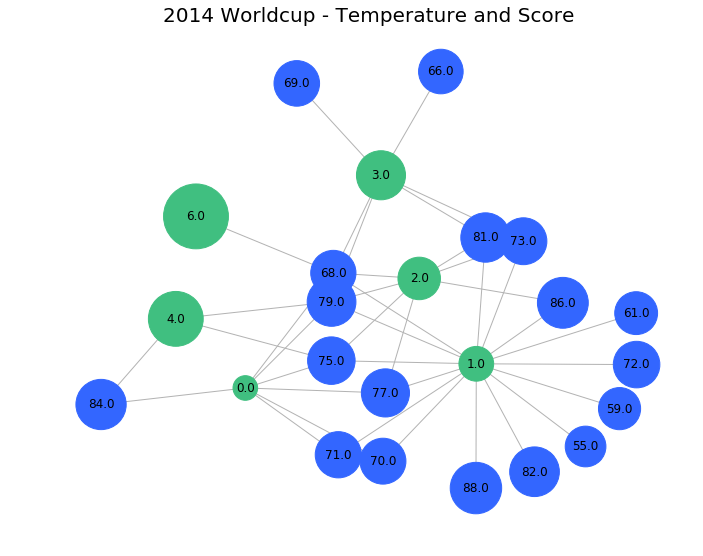

In [238]:
plt.rcParams['figure.figsize'] = [9, 7]
temperature_graph = nx.draw_kamada_kawai(B, 
                                    node_color=nd_color,
                                    edge_color='#b3b3b3',   
                                    node_size=nd_size,
                                    node_shape='o',
                                    with_labels=True, 
                                    width = 1)
plt.axis('off')
plt.title("2014 Worldcup - Temperature and Score",fontsize=20)
plt.show()

### Draw the network of temparature

In [209]:
def edge_weight_goals(G, u, v, weight='goldif'):
    w = 0
    for nbr in set(G[u]) & set(G[v]):
        w += G[u][nbr].get(weight, 1) + G[v][nbr].get(weight, 1)
    return w
G_tmpt = bi.generic_weighted_projected_graph(B, top_nodes, weight_function = edge_weight_goals)

In [270]:
weights=[]
for u,v in G_tmpt.edges:
    weights.append(G_tmpt.edges[(u,v)]['weight'])
set(weights)

{0.0, 2.0, 6.0, 8.0, 12.0, 14.0}

## 3.2 Extract the important nodes by trimming the network

### Trimming the unipartite network graph by removal of the teams conneted by relative lower edge weight (<span style="color:magenta;font-size: 26px">sum of the number of goal differential of two connected nodes under certain temperature</span>) will be helpful in find the best temperature. To determine where to place the “water level”, we plot a  <span style="color:magenta;font-size: 26px">histogram of edge weights</span> . The <span style="color:red;font-size: 26px"> Y-axis</span> in the histogram is <span style="color:cyan;font-size: 26px">the counts</span>  of <span style="color:red;font-size: 26px">each category of edge weight</span>  in the unipartite network graph. This histogram tells us that most of the edge (85/(85+25+3+5+2), ~70%) with the sum of the number of goal differential between two connected nodes in the unipartite network as 2.

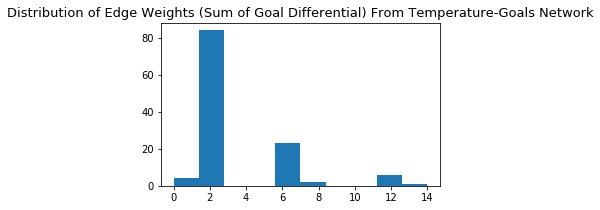

In [271]:
plt.figure(figsize=(5, 3))

plt.hist(weights)

plt.title("Distribution of Edge Weights (Sum of Goal Differential) From Temperature-Goals Network",fontsize=13)
plt.show()

### From the histogram, we can see there are 6 different weights: 0, 2, 6, 8, 12, and 14, which represnet the number of goal differential of two connected nodes under certain temperature. Approximately 70% of edges are weighted 2, so we can safely remove them.

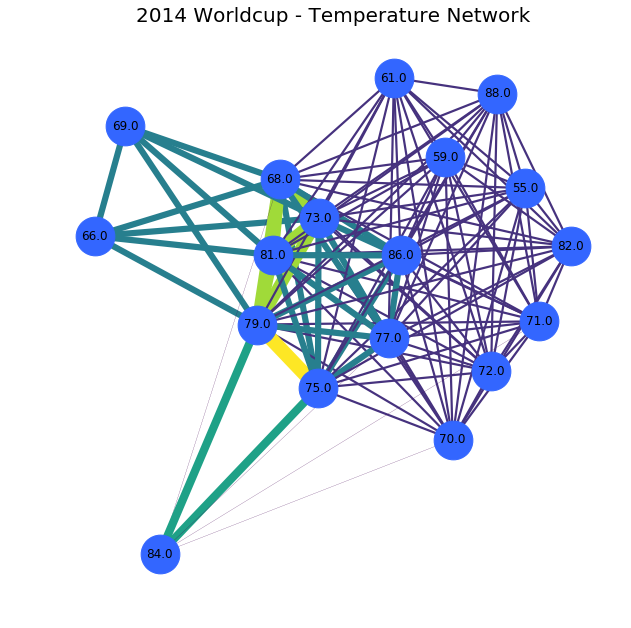

In [212]:
weights = [x+0.2 for x in weights]
plt.rcParams['figure.figsize'] = [8, 8]
one_mode_graph = nx.draw(G_tmpt,
                     node_color="#3366ff",
                     edge_color=weights,   
                     node_size=1500,
                     node_shape='o',
                     with_labels=True, 
                     width=weights)
plt.axis('off')
plt.title("2014 Worldcup - Temperature Network",fontsize=20)
plt.show()

### Separate the graph into subparts using the island method

In [213]:
def island_method(g, iterations=1):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))

    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [214]:
cc=sorted(nx.connected_component_subgraphs(G_tmpt), key = len, reverse=True)[0]
islands=island_method(cc,iterations=3)
sorted(nx.connected_component_subgraphs(islands[0][1]), key = len, reverse=True)

for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print (i[0],len(i[1]),len(sorted(nx.connected_component_subgraphs(i[1]), key = len, reverse=True)))

0 18 1
4 10 1
8 5 1
12 2 1


### By iterating different cut-off from 0 to 12 with step as 4, we got four trimed graphs with number of nodes as 18, 10, 5, and 2 respectively. None of the trimed graph has more than one subgraph.

### There is 80% edge weight (sum of goals between two nodes) are below 2, so we remove those temperature connected by edges which weight are less than 2 to get a clear view of the network.

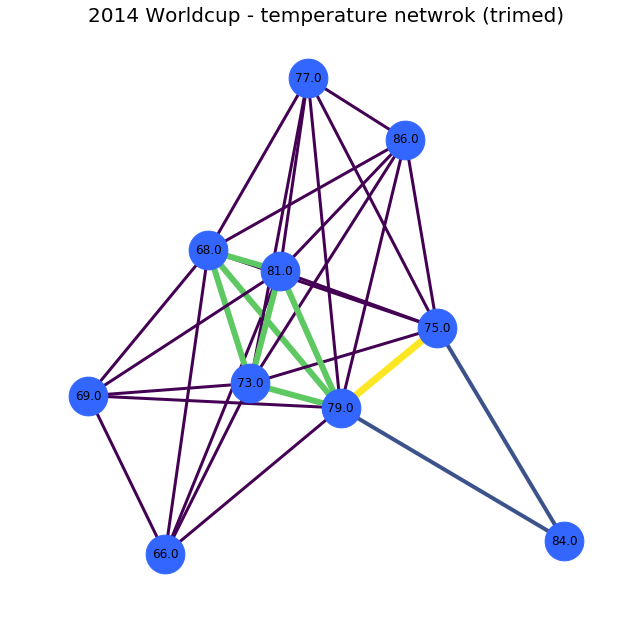

In [215]:
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
    return g2

tmpt_trim=trim_edges(G_tmpt, weight=2)

## re-calculate weights based on the new graph
## assign exponentiation weight to edges for better view
weights=[edata['weight']/2 for u,v,edata in tmpt_trim.edges(data=True)]

plt.rcParams['figure.figsize'] = [8, 8]
one_mode_graph = nx.draw(tmpt_trim,
                     node_color="#3366ff",
                     edge_color=weights,   
                     node_size=1500,
                     node_shape='o',
                     with_labels=True, 
                     width=weights)
plt.axis('off')
plt.title("2014 Worldcup - temperature netwrok (trimed)",fontsize=20)
plt.show()

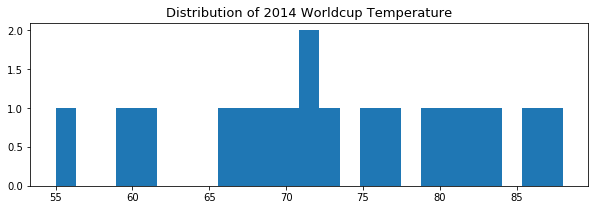

In [216]:
plt.figure(figsize=(10, 3))
bottom_nodes, top_nodes = bi.sets(B)
plt.hist(list(top_nodes),bins=25)

plt.title("Distribution of 2014 Worldcup Temperature",fontsize=13)
plt.show()

## Conclusion:

### When temperature is between 73 F and 81 F, teams tend to score more goals in the match. Lower than 73 F or higher than 81 F, team will score less goals (with the exception of 69 F an 77 F).

# 4. The relationship between the humidity and the score.


## 4.1 Bipartitie network of humidity and teams with goals as the edge weight.

In [217]:
a = wcm[wcm.Year == 2014.0] [['goldif','humidity']]
a['duplicated'] = wcm[wcm.Year == 2014.0] [['goldif','humidity']].duplicated(keep=False)
a.groupby(a.columns.tolist()).apply(lambda x: tuple(x.index)).tolist()

[(797, 809),
 (825,),
 (779,),
 (830,),
 (819,),
 (813,),
 (794,),
 (777,),
 (829,),
 (798,),
 (804,),
 (833,),
 (775, 821),
 (832,),
 (827,),
 (802,),
 (788,),
 (790,),
 (776,),
 (772, 799),
 (782, 803),
 (796,),
 (805,),
 (818,),
 (826,),
 (795, 835),
 (808,),
 (773, 792),
 (811,),
 (822,),
 (789,),
 (807, 810),
 (774, 783),
 (828,),
 (787,),
 (834,),
 (815,),
 (812,),
 (823,),
 (800,),
 (785,),
 (781, 831),
 (817,),
 (780,),
 (816,),
 (806,),
 (820,),
 (824,),
 (786,),
 (814,),
 (791,),
 (793,),
 (784,),
 (801,),
 (778,)]

### Average the weights(humidity) of duplicate edges

In [218]:
humi_2014 = wcm[wcm.Year == 2014.0]

humi_2014['goldif'].loc[[797]] = humi_2014['goldif'].loc[[797, 809]].mean(axis=0)
humi_2014['goldif'].loc[[775]] = humi_2014['goldif'].loc[[775, 821]].mean(axis=0) 
humi_2014['goldif'].loc[[772]] = humi_2014['goldif'].loc[[772, 799]].mean(axis=0) 
humi_2014['goldif'].loc[[782]] = humi_2014['goldif'].loc[[782, 803]].mean(axis=0)
humi_2014['goldif'].loc[[795]] = humi_2014['goldif'].loc[[795, 835]].mean(axis=0) 
humi_2014['goldif'].loc[[773]] = humi_2014['goldif'].loc[[773, 792]].mean(axis=0)
humi_2014['goldif'].loc[[807]] = humi_2014['goldif'].loc[[807, 810]].mean(axis=0) 
humi_2014['goldif'].loc[[774]] = humi_2014['goldif'].loc[[774, 783]].mean(axis=0) 
humi_2014['goldif'].loc[[781]] = humi_2014['goldif'].loc[[781, 831]].mean(axis=0)


t = humi_2014.loc[[809,821,799,803,835,792,810,783,831]]

humi_2014 = humi_2014.drop(t.index, axis=0)


In [219]:
humi_2014['humidity'] = [x*100 for x in humi_2014['humidity']]

humi_2014['humidity'] = humi_2014['humidity'].map('{:,.0f}'.format)

In [220]:
humi_2014['humidity'] = [int(x) for x in humi_2014['humidity']]
humi_2014['humidity'].dtypes

dtype('int64')

In [239]:
B = nx.Graph()
B = nx.from_pandas_edgelist(humi_2014, 'goldif', 'humidity', edge_attr=['goldif'])

#B = nx.Graph()
#B.add_nodes_from(humi_2014['goldif'],  bipartite=0)
#B.add_nodes_from(humi_2014['humidity']*100, bipartite=1)
#B.add_edges_from(list(zip(humi_2014['goldif'], humi_2014['humidity']*100)))

sorted(nx.connected_component_subgraphs(B), key = len, reverse=True)

**There is one subgraphs.**

In [240]:
bi.is_bipartite(B)

True

In [241]:
len(humi_2014) == B.number_of_edges()

True

### Node size and edge size

In [242]:
bottom_nodes, top_nodes = bi.sets(B)

nd_color = []
for nd in B.nodes():
    if nd < 7.0:
        nd_color.append('#40bf80')
    else:
        nd_color.append('#3366ff')

nd_size = []
for nd in B.nodes():
    if nd < 7.0:
        nd_size.append((nd+1)*20)
    else:
        nd_size.append(nd)

nd_size = [(x+0.2)*30 for x in nd_size]

### Draw the network

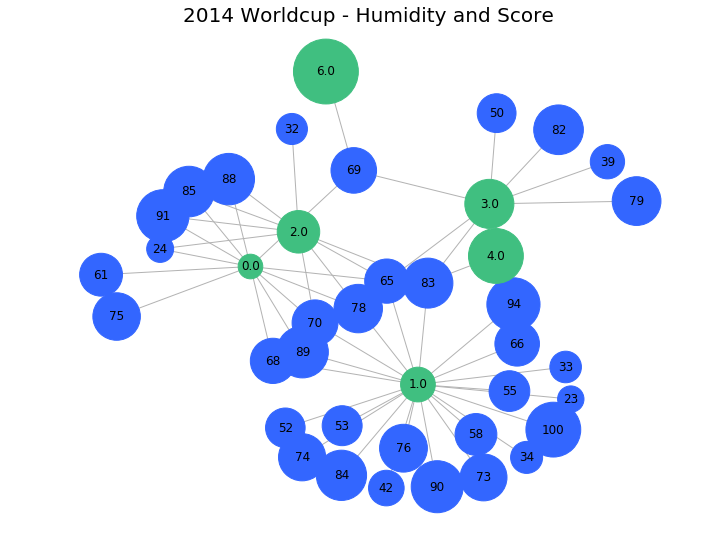

In [243]:
plt.rcParams['figure.figsize'] = [9, 7]
temperature_graph = nx.draw_kamada_kawai(B, 
                                    node_color=nd_color,
                                    edge_color='#b3b3b3',   
                                    node_size=nd_size,
                                    node_shape='o',
                                    with_labels=True, 
                                    width = 1)
plt.axis('off')
plt.title("2014 Worldcup - Humidity and Score",fontsize=20)
plt.show()

### Draw the network of humidity

In [267]:
G_humi = bi.generic_weighted_projected_graph(B, top_nodes, weight_function = edge_weight_goals)

In [268]:
weights=[]
for u,v in G_humi.edges:
    weights.append(G_humi.edges[(u,v)]['weight'])
set(weights)

{0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0}

## 4.2 Extract the important nodes by trimming the network

### Trimming the unipartite network graph by removal of the teams conneted by relative lower edge weight (<span style="color:magenta;font-size: 26px">sum of the number of goal differential of two connected nodes under certain temperature</span>) will be helpful in find the best temperature. To determine where to place the “water level”, we plot a  <span style="color:magenta;font-size: 26px">histogram of edge weights</span> . The <span style="color:red;font-size: 26px"> Y-axis</span> in the histogram is <span style="color:cyan;font-size: 26px">the counts</span>  of <span style="color:red;font-size: 26px">each category of edge weight</span>  in the unipartite network graph. This histogram tells us that most of the edge (220/(40+220+35+35+5+5+2), ~70%) with the sum of the number of goal differential between two connected nodes in the unipartite network as 2.

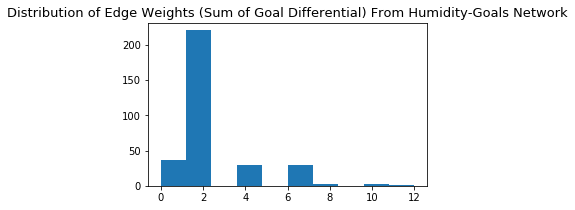

In [269]:
plt.figure(figsize=(5, 3))

plt.hist(weights)

plt.title("Distribution of Edge Weights (Sum of Goal Differential) From Humidity-Goals Network",fontsize=13)
plt.show()

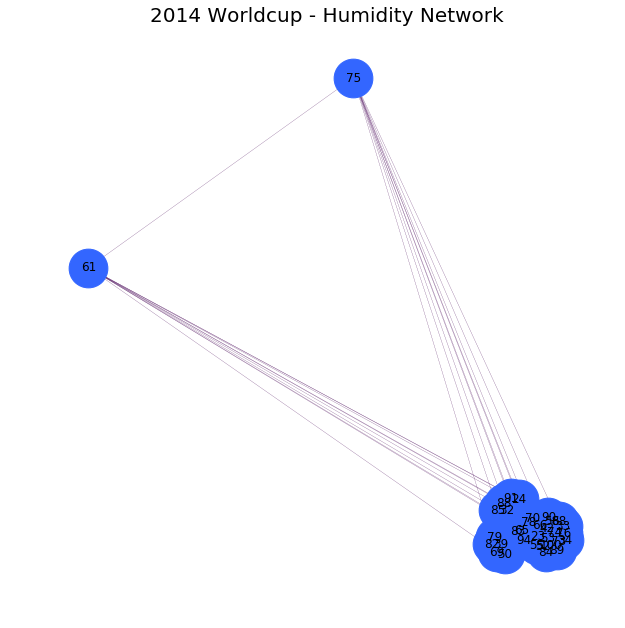

In [266]:
weights = [x+0.2 for x in weights]

plt.rcParams['figure.figsize'] = [8, 8]
one_mode_graph = nx.draw(G_humi,
                     node_color="#3366ff",
                     edge_color=weights,   
                     node_size=1500,
                     node_shape='o',
                     with_labels=True, 
                     width=weights)
plt.axis('off')
plt.title("2014 Worldcup - Humidity Network",fontsize=20)
plt.show()

### Separate the graph into subparts using the island method

In [253]:
def island_method(g, iterations=1):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))

    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [254]:
cc=sorted(nx.connected_component_subgraphs(G_tmpt), key = len, reverse=True)[0]
islands=island_method(cc,iterations=3)
sorted(nx.connected_component_subgraphs(islands[0][1]), key = len, reverse=True)

for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print (i[0],len(i[1]),len(sorted(nx.connected_component_subgraphs(i[1]), key = len, reverse=True)))

0 18 1
4 10 1
8 5 1
12 2 1


By interating different cut-off from 0 to 12 with step as 4, we got four trimed graphs with number of nodes as 18, 10, 5, and 2 respectively. None of the trimed graph has more than one subgraph.

### Trim the network

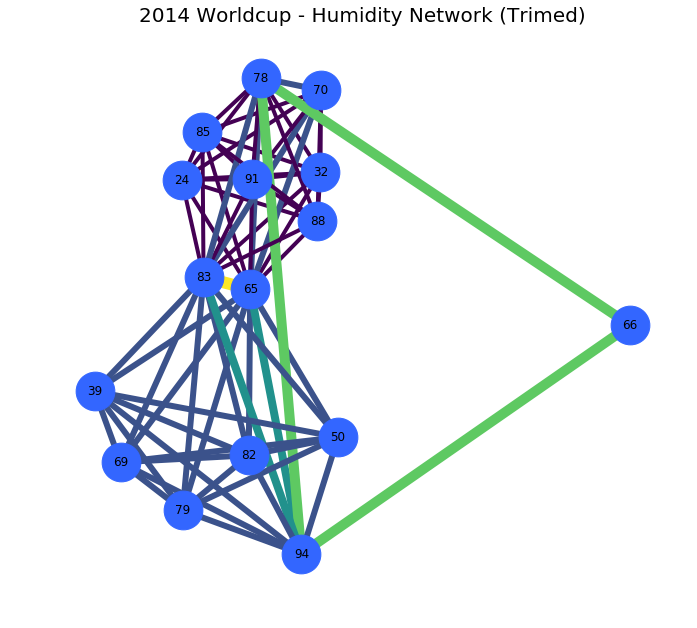

In [262]:
humi_trim=trim_edges(G_humi, weight=3)

## re-calculate weights based on the new graph
## assign exponentiation weight to edges for better view
weights=[edata['weight'] for u,v,edata in humi_trim.edges(data=True)]

plt.rcParams['figure.figsize'] = [9, 8]
one_mode_graph = nx.draw_kamada_kawai(humi_trim,
                     node_color="#3366ff",
                     edge_color=weights,   
                     node_size=1500,
                     node_shape='o',
                     with_labels=True, 
                     width=weights)
plt.axis('off')
plt.title("2014 Worldcup - Humidity Network (Trimed)",fontsize=20)
plt.show()

## Coclusion:

### There is no pattern showing teams did better under certain range of humidity values.